# Audio Preprocessing 

**Summary**

In this notebook we will be converting the audio wave files into augmented spectrograms and allocating them to their respective classes. We created the class, AudioTransformer, to load in an audio .wav file with a set sample rate of 22050 and setting the file to mono. Librosa offers to set these parameters as we load in the file which helps keep the formatting of the data consistent. The AudioTransformer class will be run through a for loop that reads each 859 unique audio files from the dataset created in the eda_audio notebook. The same_length function ensures all signal lengths are equal which will allow each spectrogram's x-axis (time) to be the same. The functions time_shift, transpose, and aug_sepctrogram are different methods of feature augmentation that were used to test the model. Different arrangements of functions were used and excluded to create a variety of different spectrograms for the model to be trained on. 

Different Spectrograms used:
- Mel-Spectrograms
- Spectrograms
- Mel-Spectrograms with ticks and a colorbar
- Normalized spectrograms using StandardScalar

Feature augmentation to create more data:
- time_shift: shifts the audio to a random starting point within the set signal length of 50,000
- transpose: takes the audio signal and doubles it to be exactly on higher than its original 
- aug_spectrogram: masks a bar of the y and x axis and random widths by setting those axis areas to 0. This is intended to prevent overfitting but did not perform well in my models. 

By creating a set of original spectrograms, a set with only time_shift, a set with only transpose, and a set with both transpose and time_shift, enabled me to quadruple my data. 


In [1]:
import librosa 
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
# reading in the dataset with all the file name paths
audio_files = pd.read_csv('../audio_files/audio_files.csv')

In [3]:
class AudioTransformer:

    max_len = 50000

    def __init__(self, aud):
        self.aud = aud # audio name file path
        self.sig = aud[0] # audio time-series as an ndarray
        self.sr = aud[1] # sample rate of audio (number of samples taken per second)
        self.S_dB = None # signal converted to decibels to be able to display 
        self.augmented_melspec = None # spectrogram with masking 
        self.spectrogram_db_normalized = None # spectrogram normalized with StandardScalar 

    def open_audio(self):
        self.sig, self.sr = librosa.load(self.aud, sr=22050, mono=True)

    def same_length(self):
        sig_len = len(self.sig)
        
        if (sig_len > self.max_len):
            self.sig = self.sig[:self.max_len]
            
        elif (sig_len < self.max_len):
            diff = self.max_len - sig_len
            for i in range(0, diff):
                self.sig = np.append(self.sig, 0)

    def time_shift(self):
        shift = int(random.random() * len(self.sig))
        self.sig = np.roll(self.sig, shift)

        
    def transpose(self):
        self.sig = librosa.effects.pitch_shift(self.sig, sr=self.sr, n_steps=12,
                                         bins_per_octave=12)
    
    def to_spectrogram(self):
        S = librosa.feature.melspectrogram(y=self.sig, sr=self.sr, n_mels=128, fmax=8000)
        self.S_dB = librosa.power_to_db(S, ref=np.max)  
        scaler = StandardScaler() # For z-score normalization
        self.spectrogram_db_normalized = scaler.fit_transform(self.S_dB.reshape(-1, 1))
        self.spectrogram_db_normalized = self.spectrogram_db_normalized.reshape(self.S_dB.shape)

    def aug_sepctrogram(self, max_mask_pct=0.1):
        freq, time = self.S_dB.shape
        self.augmented_melspec = self.S_dB.copy()
        freq_mask_param = max_mask_pct * freq
        time_mask_param = max_mask_pct * time

        # Code copied and edited from 
        # https://www.kaggle.com/code/davids1992/specaugment-quick-implementation
        
        # Frequency masking
        num_freqs_to_mask = int(freq_mask_param * random.uniform(0.5, 1.5))
        f0 = int(np.random.uniform(low = 0.0, high = (freq - num_freqs_to_mask)))
        self.augmented_melspec[:, f0:(f0 + num_freqs_to_mask)] = 0
        # Time masking
        num_frames_to_mask = int(time_mask_param * random.uniform(0.5, 1.5))
        t0 = int(np.random.uniform(low = 0.0, high = (time - num_frames_to_mask))) 
        self.augmented_melspec[t0:(t0 + num_frames_to_mask), :] = 0
        
    


    

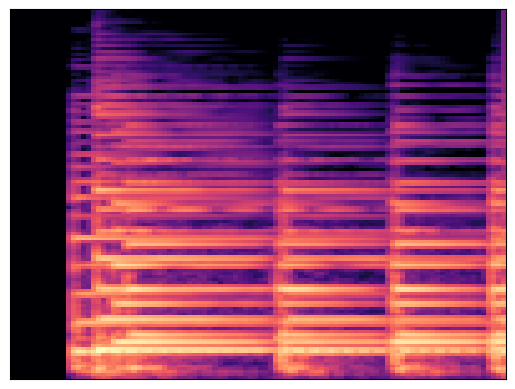

In [9]:
# Code used to test class and observe results 
aud = AudioTransformer(f'../audio_files/my_major/piano_b_maj7_3.wav')
aud.open_audio()
aud.same_length()
aud.to_spectrogram()
librosa.display.specshow(aud.S_dB, sr=aud.sr);
# plt.savefig('../images/scaled_mel_spec.jpg')
# Image = Normalized Mel-Spectrogram using Standard Scaler 

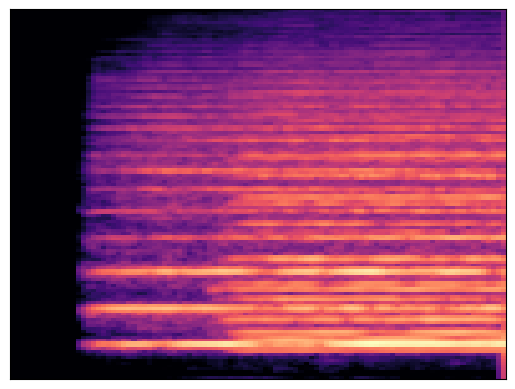

In [10]:
# Code used to test class and observe results 
aud = AudioTransformer(f'../audio_files/my_minor/violin_e_min7_2.wav')
aud.open_audio()
aud.same_length()
#aud.transpose()
aud.to_spectrogram()
librosa.display.specshow(aud.S_dB, sr=aud.sr);
# Image = Normalized Mel-Spectrogram using Standard Scaler 

In [21]:
# Used to save spectrograms generated from every file path name in the audio_files dataset. 
for i in audio_files['chord_qual']:
    if 'min' not in i:
        aud_maj = AudioTransformer(f'../audio_files/Major/{i}')
        aud_maj.open_audio()
        aud_maj.same_length()
        #aud_maj.time_shift()
        #aud_maj.transpose()
        aud_maj.to_spectrogram()
        #aud_maj.aug_sepctrogram()
        librosa.display.specshow(aud_maj.S_dB, sr=aud_maj.sr);
        plt.savefig(f'../data/scale_major/t_shft_scale_{i[:-4]}.png')
        plt.close()
    
    if 'min' in i:
        aud_min = AudioTransformer(f'../audio_files/Minor/{i}')
        aud_min.open_audio()
        aud_min.same_length()
        aud_min.time_shift()
        aud_min.transpose()
        aud_min.to_spectrogram()
        #aud_min.aug_sepctrogram()
        librosa.display.specshow(aud_min.S_dB, sr=aud_min.sr);
        plt.savefig(f'../data/scale_minor/t_shft_scale_{i[:-4]}.png')
        plt.close()